In [1]:
!pip install keras
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install sklearn

  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/fe/58/34d4d8f1aa11120c2d36d7ad27d0526164b1a8ae45990a2fede31d0e59bf/keras-2.14.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 991.0 kB/s eta 0:00:02
   -- ------------------------------------- 0.1/1.7 MB 1.4 MB/s eta 0:00:02
   ---- ----------------------------------- 0.2/1.7 MB 1.7 MB/s eta 0:00:01
   ------ --------------------------------- 0.3/1.7 MB 1.8 MB/s eta 0:00:01
   --------- ------------------------------ 0.4/1.7 MB 1.7 MB/s eta 0:00:01
   ---------- ----------------------------- 0.5/1.7 MB 1.7 MB/s eta 0:00:01
   ------------- -------------------------- 0.6/1.7 MB 1.8 MB/s eta 0:00:01
   ---------------- ----------------------- 0.7/1.7 MB 1.8 MB/s eta 0:00:01
   ----------------- ---------------------- 0.8/1.7 MB 1.9 MB/s eta 0:00:01
   -------------------- ------------------- 0.9/1

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sklearn: filename=sklearn-0.0.post9-py3-none-any.whl size=2970 sha256=fa7163dce2e7cc6d64fd38c216349978a80045e71d68fbdafb3c3b124bd6a2ed
  Stored in directory: c:\users\hitesh patil\appdata\local\pip\cache\wheels\ef\63\d1\f1671e1e93b7ef4d35df483f9b2485e6dd21941da9a92296fb
Successfully built sklearn


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

#Load the data of FB stock prices
prices = pd.read_csv('FB-stock-prices.csv')

print(prices.dtypes)
prices.head

Date     object
Price     int64
dtype: object


<bound method NDFrame.head of            Date  Price
0      1/4/2021    269
1      1/5/2021    271
2      1/6/2021    263
3      1/7/2021    269
4      1/8/2021    268
..          ...    ...
246  12/23/2021    335
247  12/27/2021    346
248  12/28/2021    346
249  12/29/2021    343
250  12/30/2021    344

[251 rows x 2 columns]>

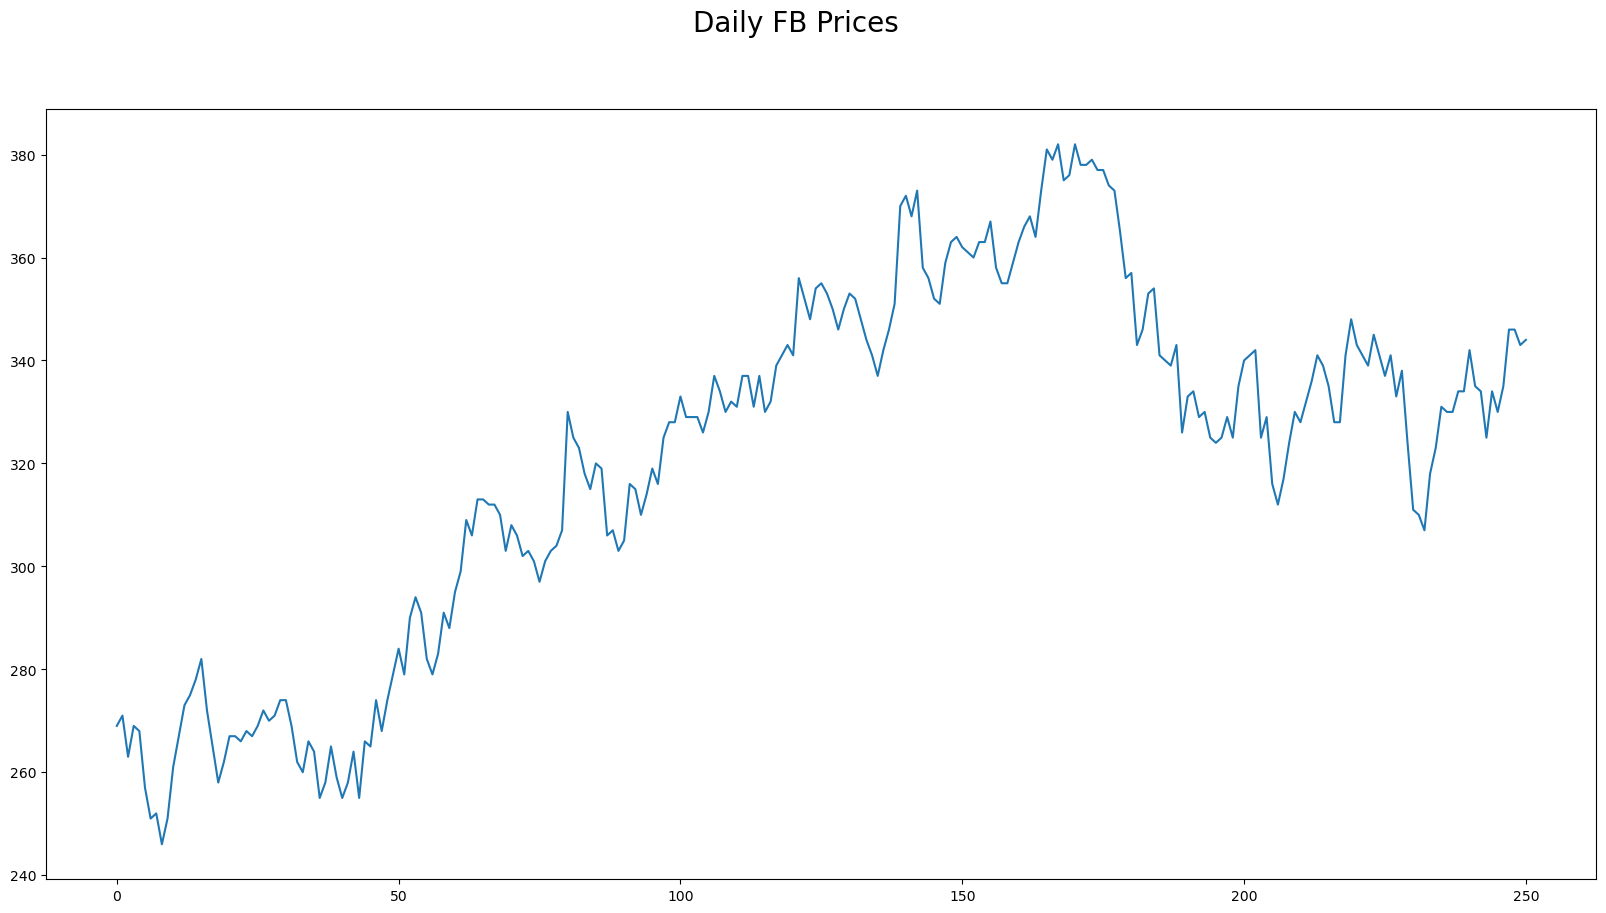

In [7]:
plt.figure(figsize=(20, 10)).suptitle("Daily FB Prices", fontsize=20)
plt.plot(prices["Price"])
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_prices = scaler.fit_transform(prices[["Price"]].values)

total_size = len(scaled_prices)

test_size = 50

train_size = total_size - test_size
print(train_size, test_size)

training_prices = scaled_prices[0:train_size,:]
test_prices = scaled_prices[train_size:,:]

print(training_prices.shape, test_prices.shape)

201 50
(201, 1) (50, 1)


In [19]:
def create_rnn_dataset(data, lookback = 1):
    
    data_x, data_y = [], []
    for i in range(len(data) - lookback - 1):
        a = data[i: (i + lookback), 0]
        data_x.append(a)
        data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

lookback = 25

train_req_x, train_req_y = create_rnn_dataset(training_prices, lookback)

train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (175, 1, 25) (175,)


In [26]:
from keras.models import Sequential 
from keras.layers import SimpleRNN, Dense
import tensorflow as tf

tf.random.set_seed(3)

price_model=Sequential()
price_model.add(SimpleRNN(32, input_shape=(1, lookback)))

price_model.add(Dense(1))

price_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

price_model.summary()

price_model.fit(train_req_x, train_req_y, 
             epochs=5, batch_size=1, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 32)                1856      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1889 (7.38 KB)
Trainable params: 1889 (7.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
175/175 [==============================] - 1s 1ms/step - loss: 0.1535 - mse: 0.1535
Epoch 2/5
175/175 [==============================] - 0s 1ms/step - loss: 0.0466 - mse: 0.0466
Epoch 3/5
175/175 [==============================] - 0s 1ms/step - loss: 0.0403 - mse: 0.0403
Epoch 4/5
175/175 [==============================] - 0s 1ms/step - loss: 0.0378 - mse: 0.0378
Epoch 5/5
175/175 [=======================

In [29]:
test_req_x, test_req_y = create_rnn_dataset(test_prices,lookback)

print(test_req_x.shape, test_req_y.shape)

test_req_x = np.reshape(test_req_x, 
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

#Evaluate the model
price_model.evaluate(test_req_x, test_req_y, verbose=1)

#Predict on the test dataset
predict_on_test = price_model.predict(test_req_x)

#Inverse the scaling to view results
predict_on_test = scaler.inverse_transform(predict_on_test)

(24, 25) (24,)
1/1 [==============================] - 0s 136ms/step


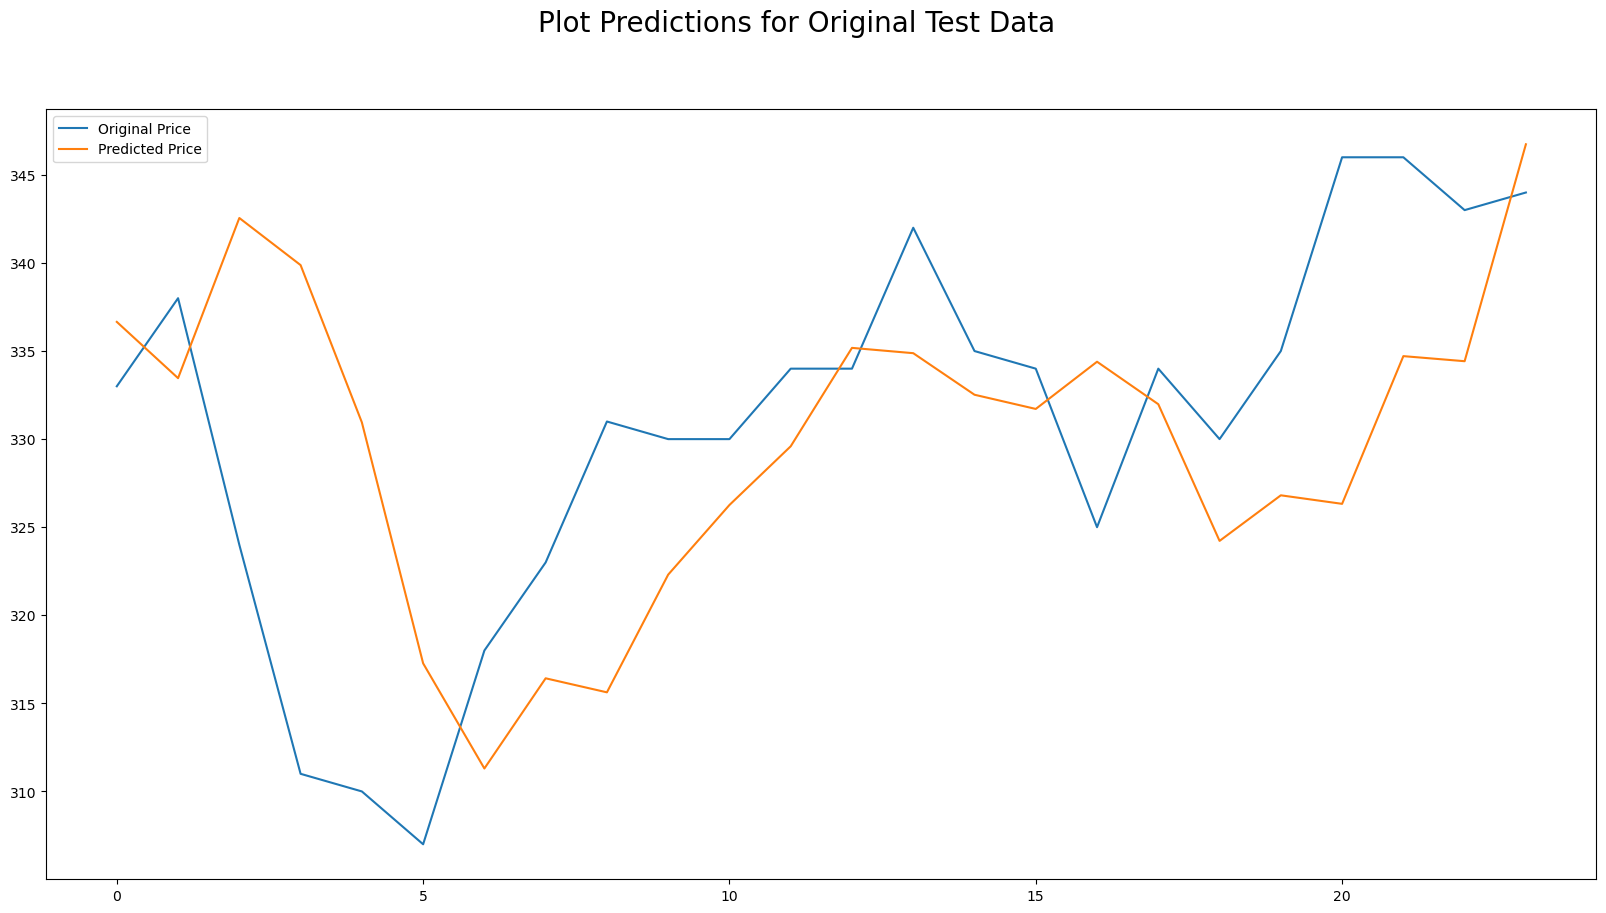

In [30]:
#Extract original test values that map to the same dates on the predicted test values
orig_test_values = prices[["Price"]].loc[total_size-len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original Test Data", fontsize=20)
plt.plot(orig_test_values, label="Original Price")
plt.plot(predict_on_test, label="Predicted Price")
plt.legend()
plt.show()

In [36]:
previous_prices = np.array([325,335,340,341,342,
                            325,329,316,312,317,
                            324,330,328,332,336,
                            341,339,335,328,328,
                            341,348,343,341,339])

scaled_prices = scaler.transform(previous_prices.reshape(-1, 1))

model_input = np.reshape(scaled_prices, 
                         (scaled_prices.shape[1],1, scaled_prices.shape[0]))

prediction = price_model.predict(model_input)

norm_prediction = scaler.inverse_transform(prediction)

print("The predicted Stock price is :", norm_prediction[0][0])

1/1 [==============================] - 0s 21ms/step
The predicted Stock price is : 338.9754
